<a href="https://colab.research.google.com/github/Marcin19721205/BasicTrainingPython/blob/main/PROJEKT_SIECI_NEURONOWE_z_augmentacja.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Grupa projektowa: Marcin Jabłoński / Marta Niebrzegowska

### Spis treści:
1. [Import bibliotek](#0)
2. [Zbiór danych Cifar](#1)
3. [Standaryzacja](#2)
4. [PCA - 2 komponenty](#3)
5. [PCA - 3 komponenty](#4)
6. [Zbiór danych MNIST](#5)
7. [Zbiór danych Cifar](#6)




### <a name='0'></a> Import bibliotek

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

np.set_printoptions(precision=4, suppress=True, linewidth=150)


import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.decomposition import PCA

### <a name='0'></a> Zbiór danych Cifar

In [21]:
#wczytanie CIFAR10
(cifar10_X_train_raw, cifar10_y_train_raw), (cifar10_X_test_raw, cifar10_y_test_raw) = cifar10.load_data()

print("cifar10_X_train_raw:", cifar10_X_train_raw.shape)
print("cifar10_y_train_raw:", cifar10_y_train_raw.shape)
print("cifar10_X_test_raw:", cifar10_X_test_raw.shape)
print("cifar10_y_test_raw:", cifar10_y_test_raw.shape)

# spłaszczenie etyiet do wektora 1D
cifar10_y_train = cifar10_y_train_raw.reshape(-1)
cifar10_y_test  = cifar10_y_test_raw.reshape(-1)


cifar10_X_train_raw: (50000, 32, 32, 3)
cifar10_y_train_raw: (50000, 1)
cifar10_X_test_raw: (10000, 32, 32, 3)
cifar10_y_test_raw: (10000, 1)


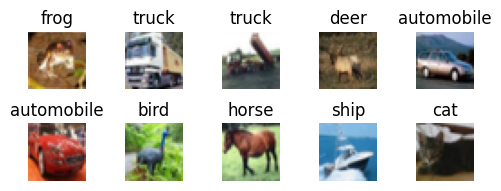

In [22]:
# szybki podgląd obrazków
cifar10_class_names = [
    "airplane","automobile","bird","cat","deer",
    "dog","frog","horse","ship","truck"
]

plt.figure(figsize=(5, 2))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(cifar10_X_train_raw[i])
    plt.title(cifar10_class_names[cifar10_y_train[i]])
    plt.axis("off")
plt.tight_layout()
plt.show()


In [23]:
cifar10_y_test_raw[:5]

array([[3],
       [8],
       [8],
       [0],
       [6]], dtype=uint8)

Standaryzacja

In [24]:
# skalowanie + standaryzacja per-kanał (train)
cifar10_X_train_scaled = cifar10_X_train_raw.astype(np.float32) / 255.0  # konwersja na float32 + skalowanie pikseli z [0..255] do [0..1]
cifar10_X_test_scaled  = cifar10_X_test_raw.astype(np.float32) / 255.0   # to samo dla testu; ujednolica zakres i stabilizuje uczenie (mniej “rozjechanych” gradientów)

# mean/std po (N,H,W) osobno dla kanałów RGB
cifar10_mean_ch = cifar10_X_train_scaled.mean(axis=(0, 1, 2), keepdims=True)  # liczysz średnią osobno dla R,G,B po całym zbiorze treningowym (po N,H,W)
cifar10_std_ch  = cifar10_X_train_scaled.std(axis=(0, 1, 2), keepdims=True) + 1e-7  # liczysz odchylenie std dla R,G,B; +1e-7 to bezpiecznik, żeby nie dzielić przez 0

cifar10_X_train_std = (cifar10_X_train_scaled - cifar10_mean_ch) / cifar10_std_ch  # standaryzacja train: każdemu kanałowi nadajesz mean≈0 i std≈1 (szybsza, stabilniejsza optymalizacja)
cifar10_X_test_std  = (cifar10_X_test_scaled  - cifar10_mean_ch) / cifar10_std_ch  # standaryzacja testu TYM SAMYM mean/std z train (żadnego “podglądania” testu → brak data leakage)

print("mean RGB:", cifar10_mean_ch.reshape(-1))     # wypisuje 3 wartości średnich dla kanałów: [mean_R, mean_G, mean_B] (reshape(-1) spłaszcza do 1D)
print("std  RGB:", cifar10_std_ch.reshape(-1))      # wypisuje 3 wartości odchyleń std dla kanałów: [std_R, std_G, std_B]
print("train std shape:", cifar10_X_train_std.shape) # kontrola kształtu po przekształceniach (powinno zostać N×H×W×3)


mean RGB: [0.4914 0.4822 0.4465]
std  RGB: [0.247  0.2435 0.2616]
train std shape: (50000, 32, 32, 3)


Augmentacja

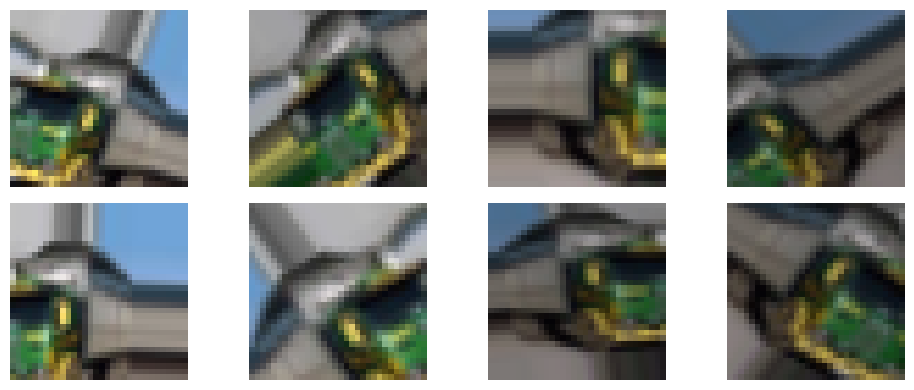

In [25]:
# Augumentacja - przykład działania
# augmentacja CIFAR10 + podgląd (pewna wersja: RAW uint8 + rescale)

# generator augmentacji
cifar10_datagen_aug = ImageDataGenerator(
    rescale=1.0/255.0,          # RAW 0..255 -> float 0..1
    width_shift_range=0.3,
    height_shift_range=0.3,
    rotation_range=45,
    brightness_range=[0.7, 1.3],
    zoom_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode="nearest"
)

# 3) iterator dla wybranego obrazu
cifar10_x0_raw = cifar10_X_train_raw[14]                 # (32,32,3) uint8, [numer obrazka]
cifar10_it = cifar10_datagen_aug.flow(
    np.expand_dims(cifar10_x0_raw, axis=0),             # (1,32,32,3)
    batch_size=1,
    shuffle=False,
    seed=123
)

# 4) podgląd 8 augmentacji
plt.figure(figsize=(10, 4))
for i in range(8):
    x_aug = next(cifar10_it)[0]                         # (32,32,3) float w [0..1]
    plt.subplot(2, 4, i + 1)
    plt.imshow(np.clip(x_aug, 0.0, 1.0))
    plt.axis("off")

plt.tight_layout()
plt.show()


Augmentacja własciwa - dodajemy do train

In [26]:
# --- AUGMENTACJA -> DODANIE DO TRAIN (bez _use, nadpisujemy cifar10_X_train_std / cifar10_y_train) ---

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

cifar10_aug_n_extra = 50000
cifar10_aug_batch   = 256
cifar10_aug_seed    = 123

cifar10_datagen_aug = ImageDataGenerator(
    rescale=1.0/255.0,
    width_shift_range=0.3,
    height_shift_range=0.3,
    rotation_range=45,
    brightness_range=[0.7, 1.3],
    zoom_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode="nearest"
)

cifar10_it_aug = cifar10_datagen_aug.flow(
    cifar10_X_train_raw,     # RAW uint8
    cifar10_y_train,         # etykiety (N,) lub one-hot
    batch_size=cifar10_aug_batch,
    shuffle=True,
    seed=cifar10_aug_seed
)

# bufory na augmenty (najpierw [0..1])
cifar10_X_train_aug_scaled = np.empty((cifar10_aug_n_extra, 32, 32, 3), dtype=np.float32)
cifar10_y_train_aug_extra  = np.empty((cifar10_aug_n_extra,), dtype=np.int64)

cifar10_filled = 0
while cifar10_filled < cifar10_aug_n_extra:
    x_batch_scaled, y_batch = next(cifar10_it_aug)

    if y_batch.ndim > 1:
        y_batch = np.argmax(y_batch, axis=1)

    take = min(len(x_batch_scaled), cifar10_aug_n_extra - cifar10_filled)

    cifar10_X_train_aug_scaled[cifar10_filled:cifar10_filled + take] = x_batch_scaled[:take]
    cifar10_y_train_aug_extra[cifar10_filled:cifar10_filled + take]  = y_batch[:take]

    cifar10_filled += take

# standaryzacja augmentów tym samym mean/std co train (bez data leakage)
cifar10_X_train_aug_std = (cifar10_X_train_aug_scaled - cifar10_mean_ch) / cifar10_std_ch

# DOŁĄCZENIE augmentów do TRAIN (nadpisujemy główne zmienne, żeby pipeline był spójny)
cifar10_X_train_std = np.concatenate([cifar10_X_train_std, cifar10_X_train_aug_std], axis=0)
cifar10_y_train     = np.concatenate([cifar10_y_train,     cifar10_y_train_aug_extra], axis=0)

# mieszanie train (żeby org/aug nie leżały blokami)
cifar10_rng  = np.random.default_rng(cifar10_aug_seed)
cifar10_perm = cifar10_rng.permutation(cifar10_X_train_std.shape[0])
cifar10_X_train_std = cifar10_X_train_std[cifar10_perm]
cifar10_y_train     = cifar10_y_train[cifar10_perm]

print("X_train_std (po aug):", cifar10_X_train_std.shape)
print("y_train     (po aug):", cifar10_y_train.shape)
print("X_test_std  (bez aug):", cifar10_X_test_std.shape)


X_train_std (po aug): (100000, 32, 32, 3)
y_train     (po aug): (100000,)
X_test_std  (bez aug): (10000, 32, 32, 3)


In [27]:
# Komórka 1 — spłaszczenie obrazów pod modele (N, 32*32*3)
#
# SPYTAJ SIĘ PO CO
cifar10_X_train_flat = cifar10_X_train_std.reshape(cifar10_X_train_std.shape[0], -1)
cifar10_X_test_flat  = cifar10_X_test_std.reshape(cifar10_X_test_std.shape[0],  -1)

print("cifar10_X_train_flat:", cifar10_X_train_flat.shape)
print("cifar10_X_test_flat :", cifar10_X_test_flat.shape)


cifar10_X_train_flat: (100000, 3072)
cifar10_X_test_flat : (10000, 3072)


Obliczenie wariancji skumulowanej dla PCA

In [28]:
# Komórka 2 — PCA: kilka wariantów n_components + zapis do słownika (pod porównania)
from sklearn.decomposition import PCA

cifar10_pca_components_list = [64, 128, 256, 512]  # warianty do porównania
cifar10_pca_bundle = {}  # tu trzymamy: model PCA + transformacje + explained variance

for cifar10_pca_n in cifar10_pca_components_list:
    cifar10_pca_model = PCA(n_components=cifar10_pca_n, random_state=123)

    cifar10_X_train_pca = cifar10_pca_model.fit_transform(cifar10_X_train_flat)  # fit tylko na train
    cifar10_X_test_pca  = cifar10_pca_model.transform(cifar10_X_test_flat)

    cifar10_pca_bundle[cifar10_pca_n] = {
        "pca_model": cifar10_pca_model,
        "X_train_pca": cifar10_X_train_pca,
        "X_test_pca": cifar10_X_test_pca,
        "explained_var_sum": float(cifar10_pca_model.explained_variance_ratio_.sum()),
    }

    print(f"PCA={cifar10_pca_n}: X_train_pca={cifar10_X_train_pca.shape}, explained_sum={cifar10_pca_bundle[cifar10_pca_n]['explained_var_sum']:.4f}")


PCA=64: X_train_pca=(100000, 64), explained_sum=0.8882
PCA=128: X_train_pca=(100000, 128), explained_sum=0.9348
PCA=256: X_train_pca=(100000, 256), explained_sum=0.9680
PCA=512: X_train_pca=(100000, 512), explained_sum=0.9879


In [29]:
# Komórka — wykres wariancji PCA jak na Twoim screenie (bar + cumulative line) dla wybranego n_components

import numpy as np
import pandas as pd
import plotly.graph_objects as go

# wybierz wariant PCA (musi istnieć w cifar10_pca_bundle)
cifar10_pca_n_plot = 512

cifar10_pca_model_plot = cifar10_pca_bundle[cifar10_pca_n_plot]["pca_model"]
cifar10_ev_ratio = cifar10_pca_model_plot.explained_variance_ratio_
cifar10_ev_cum = np.cumsum(cifar10_ev_ratio)

cifar10_pca_var_df = pd.DataFrame({
    "component": np.arange(1, len(cifar10_ev_ratio) + 1),
    "explained_variance_ratio": cifar10_ev_ratio,
    "cumulative": cifar10_ev_cum
})

fig = go.Figure(data=[
    go.Bar(
        x=cifar10_pca_var_df["component"],
        y=cifar10_pca_var_df["explained_variance_ratio"],
        name="explained_variance_ratio"
    ),
    go.Scatter(
        x=cifar10_pca_var_df["component"],
        y=cifar10_pca_var_df["cumulative"],
        mode="lines+markers",
        name="cumulative",
        yaxis="y2"
    )
])

fig.update_layout(
    title=f"CIFAR10 — PCA variance (n_components={cifar10_pca_n_plot})",
    template="plotly_dark",
    width=950,
    height=550,
    xaxis=dict(title="component"),
    yaxis=dict(title="explained_variance_ratio"),
    yaxis2=dict(
        title="cumulative",
        overlaying="y",
        side="right",
        range=[0, 1.0]
    ),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

fig.show()

# jak chcesz podejrzeć tabelę jak na screenie:
cifar10_pca_var_df.head(10)


,component,explained_variance_ratio,cumulative
0,1,0.331052,0.331052
1,2,0.111942,0.442994
2,3,0.057509,0.500504
3,4,0.052988,0.553491
4,5,0.036390,0.589881
5,6,0.026605,0.616486
6,7,0.025084,0.641570
7,8,0.022344,0.663914
8,9,0.015489,0.679403
9,10,0.015321,0.694724


In [30]:
# Komórka — PCA do wizualizacji (2D i 3D) + sampling

import numpy as np
from sklearn.decomposition import PCA

cifar10_class_names = [
    "airplane","automobile","bird","cat","deer",
    "dog","frog","horse","ship","truck"
]

# spłaszcz pod PCA
cifar10_X_train_flat = cifar10_X_train_std.reshape(cifar10_X_train_std.shape[0], -1)

# sampling do plotów (żeby Plotly nie umarł)
cifar10_viz_n = 5000
rng = np.random.default_rng(123)
cifar10_viz_idx = rng.choice(cifar10_X_train_flat.shape[0], size=cifar10_viz_n, replace=False)

cifar10_X_train_flat_viz = cifar10_X_train_flat[cifar10_viz_idx]
cifar10_y_train_viz = cifar10_y_train[cifar10_viz_idx]

# PCA 2D i 3D (tylko pod wykresy)
cifar10_pca_viz2_model = PCA(n_components=2, random_state=123)
cifar10_X_train_pca2_viz = cifar10_pca_viz2_model.fit_transform(cifar10_X_train_flat_viz)

cifar10_pca_viz3_model = PCA(n_components=3, random_state=123)
cifar10_X_train_pca3_viz = cifar10_pca_viz3_model.fit_transform(cifar10_X_train_flat_viz)

print("PCA2 explained_sum:", float(cifar10_pca_viz2_model.explained_variance_ratio_.sum()))
print("PCA3 explained_sum:", float(cifar10_pca_viz3_model.explained_variance_ratio_.sum()))


PCA2 explained_sum: 0.44392716884613037
PCA3 explained_sum: 0.5049516558647156


In [31]:
# Komórka — PCA 2D scatter (Plotly)

import pandas as pd
import plotly.express as px

cifar10_pca2_df = pd.DataFrame({
    "pca_1": cifar10_X_train_pca2_viz[:, 0],
    "pca_2": cifar10_X_train_pca2_viz[:, 1],
    "class_id": cifar10_y_train_viz
})
cifar10_pca2_df["class_name"] = cifar10_pca2_df["class_id"].map(lambda k: cifar10_class_names[int(k)])

fig = px.scatter(
    cifar10_pca2_df,
    x="pca_1", y="pca_2",
    color="class_name",
    opacity=0.55,
    template="plotly_dark",
    width=1000, height=600,
    title="CIFAR10 — PCA 2D (sample)"
)
fig.show()


In [32]:
# Komórka — PCA 3D scatter (Plotly)

cifar10_pca3_df = pd.DataFrame({
    "pca_1": cifar10_X_train_pca3_viz[:, 0],
    "pca_2": cifar10_X_train_pca3_viz[:, 1],
    "pca_3": cifar10_X_train_pca3_viz[:, 2],
    "class_id": cifar10_y_train_viz
})
cifar10_pca3_df["class_name"] = cifar10_pca3_df["class_id"].map(lambda k: cifar10_class_names[int(k)])

fig = px.scatter_3d(
    cifar10_pca3_df,
    x="pca_1", y="pca_2", z="pca_3",
    color="class_name",
    opacity=0.60,
    template="plotly_dark",
    width=1000, height=700,
    title="CIFAR10 — PCA 3D (sample)"
)
fig.show()


Model PCA dla 256

In [33]:
# Komórka 1 — wybór wariantu PCA=256 + wygodne skróty do danych
cifar10_pca_n_final = 256

cifar10_pca_final_model = cifar10_pca_bundle[cifar10_pca_n_final]["pca_model"]
cifar10_X_train_pca_256 = cifar10_pca_bundle[cifar10_pca_n_final]["X_train_pca"]
cifar10_X_test_pca_256  = cifar10_pca_bundle[cifar10_pca_n_final]["X_test_pca"]

cifar10_pca_256_ev_sum = cifar10_pca_bundle[cifar10_pca_n_final]["explained_var_sum"]

print("cifar10_X_train_pca_256:", cifar10_X_train_pca_256.shape)
print("cifar10_X_test_pca_256 :", cifar10_X_test_pca_256.shape)
print("explained_var_sum:", cifar10_pca_256_ev_sum)


cifar10_X_train_pca_256: (100000, 256)
cifar10_X_test_pca_256 : (10000, 256)
explained_var_sum: 0.9679835438728333


Model Regresji Logistycznej # inicjalizacyjny kod wynikami modelu

In [34]:
# Komórka — PCA=256 + Logistic Regression (pełny run)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import pandas as pd
import plotly.express as px

# model
cifar10_clf_pca_256_lr = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=300,
    n_jobs=-1,
    random_state=123
)

# trening
cifar10_clf_pca_256_lr.fit(cifar10_X_train_pca_256, cifar10_y_train)

# predykcja
cifar10_y_pred_pca_256_lr = cifar10_clf_pca_256_lr.predict(cifar10_X_test_pca_256)

# metryki
cifar10_acc_pca_256_lr = accuracy_score(cifar10_y_test, cifar10_y_pred_pca_256_lr)
cifar10_f1m_pca_256_lr = f1_score(cifar10_y_test, cifar10_y_pred_pca_256_lr, average="macro")

print("LogReg PCA=256 | accuracy:", cifar10_acc_pca_256_lr)
print("LogReg PCA=256 | f1_macro:", cifar10_f1m_pca_256_lr)
print("\nclassification_report:\n", classification_report(cifar10_y_test, cifar10_y_pred_pca_256_lr, target_names=cifar10_class_names))

# confusion matrix
cifar10_cm_pca_256_lr = confusion_matrix(cifar10_y_test, cifar10_y_pred_pca_256_lr)

cifar10_cm_df_pca_256_lr = pd.DataFrame(
    cifar10_cm_pca_256_lr,
    index=[f"true_{c}" for c in cifar10_class_names],
    columns=[f"pred_{c}" for c in cifar10_class_names]
)

fig = px.imshow(
    cifar10_cm_df_pca_256_lr,
    text_auto=True,
    aspect="auto",
    template="plotly_dark",
    title="CIFAR10 | PCA=256 | Logistic Regression | Confusion Matrix"
)
fig.show()

# pakiet wyników do porównań
cifar10_results_pca_256_lr = {
    "model_name": "LogisticRegression",
    "pca_n": 256,
    "explained_var_sum": cifar10_pca_256_ev_sum,
    "accuracy": float(cifar10_acc_pca_256_lr),
    "f1_macro": float(cifar10_f1m_pca_256_lr),
    "confusion_matrix": cifar10_cm_pca_256_lr,
}
cifar10_results_pca_256_lr


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



LogReg PCA=256 | accuracy: 0.4033
LogReg PCA=256 | f1_macro: 0.39657471529022736

classification_report:
               precision    recall  f1-score   support

    airplane       0.46      0.46      0.46      1000
  automobile       0.44      0.52      0.47      1000
        bird       0.31      0.22      0.26      1000
         cat       0.32      0.23      0.27      1000
        deer       0.38      0.29      0.33      1000
         dog       0.33      0.35      0.34      1000
        frog       0.41      0.47      0.44      1000
       horse       0.43      0.45      0.44      1000
        ship       0.48      0.55      0.51      1000
       truck       0.40      0.51      0.45      1000

    accuracy                           0.40     10000
   macro avg       0.40      0.40      0.40     10000
weighted avg       0.40      0.40      0.40     10000



{'model_name': 'LogisticRegression',
 'pca_n': 256,
 'explained_var_sum': 0.9679835438728333,
 'accuracy': 0.4033,
 'f1_macro': 0.39657471529022736,
 'confusion_matrix': array([[455,  44,  48,  24,  13,  17,  27,  65, 207, 100],
        [ 51, 516,  18,  26,  20,  38,  38,  44,  67, 182],
        [ 90,  70, 223,  78, 116, 106, 128,  96,  64,  29],
        [ 42,  81,  78, 234,  42, 205, 124,  71,  49,  74],
        [ 56,  42, 117,  49, 288,  98, 168, 117,  26,  39],
        [ 35,  68,  91, 139,  68, 347,  82,  81,  51,  38],
        [ 13,  44,  76, 104,  97,  92, 471,  54,  17,  32],
        [ 40,  54,  56,  44,  82,  82,  43, 446,  38, 115],
        [140,  69,  10,  22,   8,  47,   8,  13, 545, 138],
        [ 58, 189,  10,  19,  16,  24,  48,  46,  82, 508]])}

Model SVC - inicjalizacyjny kod z wynikami modelu

In [35]:
# Komórka — PCA=256 + Linear SVC (pełny run)

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import pandas as pd
import plotly.express as px

# model
cifar10_clf_pca_256_svc = LinearSVC(
    C=1.0,
    random_state=123
)

# trening
cifar10_clf_pca_256_svc.fit(cifar10_X_train_pca_256, cifar10_y_train)

# predykcja
cifar10_y_pred_pca_256_svc = cifar10_clf_pca_256_svc.predict(cifar10_X_test_pca_256)

# metryki
cifar10_acc_pca_256_svc = accuracy_score(cifar10_y_test, cifar10_y_pred_pca_256_svc)
cifar10_f1m_pca_256_svc = f1_score(cifar10_y_test, cifar10_y_pred_pca_256_svc, average="macro")

print("LinearSVC PCA=256 | accuracy:", cifar10_acc_pca_256_svc)
print("LinearSVC PCA=256 | f1_macro:", cifar10_f1m_pca_256_svc)
print("\nclassification_report:\n", classification_report(cifar10_y_test, cifar10_y_pred_pca_256_svc, target_names=cifar10_class_names))

# confusion matrix
cifar10_cm_pca_256_svc = confusion_matrix(cifar10_y_test, cifar10_y_pred_pca_256_svc)

cifar10_cm_df_pca_256_svc = pd.DataFrame(
    cifar10_cm_pca_256_svc,
    index=[f"true_{c}" for c in cifar10_class_names],
    columns=[f"pred_{c}" for c in cifar10_class_names]
)

fig = px.imshow(
    cifar10_cm_df_pca_256_svc,
    text_auto=True,
    aspect="auto",
    template="plotly_dark",
    title="CIFAR10 | PCA=256 | LinearSVC | Confusion Matrix"
)
fig.show()

# pakiet wyników do porównań
cifar10_results_pca_256_svc = {
    "model_name": "LinearSVC",
    "pca_n": 256,
    "explained_var_sum": cifar10_pca_256_ev_sum,
    "accuracy": float(cifar10_acc_pca_256_svc),
    "f1_macro": float(cifar10_f1m_pca_256_svc),
    "confusion_matrix": cifar10_cm_pca_256_svc,
}
cifar10_results_pca_256_svc


LinearSVC PCA=256 | accuracy: 0.3951
LinearSVC PCA=256 | f1_macro: 0.378517019330675

classification_report:
               precision    recall  f1-score   support

    airplane       0.44      0.46      0.45      1000
  automobile       0.41      0.51      0.46      1000
        bird       0.33      0.14      0.20      1000
         cat       0.34      0.16      0.21      1000
        deer       0.39      0.26      0.31      1000
         dog       0.33      0.33      0.33      1000
        frog       0.40      0.54      0.46      1000
       horse       0.43      0.44      0.43      1000
        ship       0.43      0.59      0.50      1000
       truck       0.37      0.51      0.43      1000

    accuracy                           0.40     10000
   macro avg       0.39      0.40      0.38     10000
weighted avg       0.39      0.40      0.38     10000



{'model_name': 'LinearSVC',
 'pca_n': 256,
 'explained_var_sum': 0.9679835438728333,
 'accuracy': 0.3951,
 'f1_macro': 0.378517019330675,
 'confusion_matrix': array([[462,  45,  16,  16,  13,  16,  35,  58, 242,  97],
        [ 54, 514,   5,  10,  18,  24,  50,  46,  86, 193],
        [111,  85, 141,  45, 113, 102, 172, 103,  85,  43],
        [ 58, 100,  46, 158,  35, 209, 159,  62,  74,  99],
        [ 69,  52,  78,  32, 259,  91, 191, 139,  36,  53],
        [ 46,  80,  62,  97,  67, 330, 108,  77,  75,  58],
        [ 20,  49,  47,  57,  81,  80, 543,  54,  30,  39],
        [ 48,  71,  31,  32,  68,  79,  42, 441,  49, 139],
        [122,  65,   2,  12,   6,  37,  13,  13, 593, 137],
        [ 58, 195,   4,  11,  12,  20,  52,  38, 100, 510]])}

Przygotowanie wycinka danych do tuningu

In [36]:
# Komórka 0 — zbiór do tuningu (stratyfikowany podzbiór train), żeby GridSearch nie zabił runtime
from sklearn.model_selection import train_test_split

cifar10_tune_size = 25000  # można zmienić
cifar10_X_train_pca_256_tune, _, cifar10_y_train_tune, _ = train_test_split(
    cifar10_X_train_pca_256,
    cifar10_y_train,
    train_size=cifar10_tune_size,
    random_state=123,
    stratify=cifar10_y_train
)

print("tune X:", cifar10_X_train_pca_256_tune.shape)
print("tune y:", cifar10_y_train_tune.shape)


tune X: (25000, 256)
tune y: (25000,)


Tuner — Logistic Regression (PCA=256) - 9 fitów - dla większej ilości bardzo wolno idzie

In [37]:
# Komórka — FAST tuner LR (nadpisuje cifar10_best_params_lr_pca256)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

cifar10_cv_fast = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)

cifar10_lr_fast = LogisticRegression(
    solver="lbfgs",
    multi_class="multinomial",
    max_iter=300,
    n_jobs=-1,
    random_state=123
)

cifar10_param_grid_lr_fast = {"C": [0.3, 1.0, 3.0]}

cifar10_grid_lr_pca256_fast = GridSearchCV(
    cifar10_lr_fast,
    cifar10_param_grid_lr_fast,
    scoring="f1_macro",
    cv=cifar10_cv_fast,
    n_jobs=-1,
    verbose=2
)

cifar10_grid_lr_pca256_fast.fit(cifar10_X_train_pca_256_tune, cifar10_y_train_tune)

cifar10_best_params_lr_pca256 = cifar10_grid_lr_pca256_fast.best_params_
cifar10_best_score_lr_pca256  = float(cifar10_grid_lr_pca256_fast.best_score_)

print("BEST LR params:", cifar10_best_params_lr_pca256)
print("BEST LR cv f1_macro:", cifar10_best_score_lr_pca256)


Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



BEST LR params: {'C': 3.0}
BEST LR cv f1_macro: 0.3138437512986188


Tuner — SVC (sensowny: LinearSVC, bo klasyczny SVC z RBF na 50k to masakra) - też 9 fits, bo 24 idzie bardzo wolno

In [38]:
# Komórka 3 — GridSearchCV dla LinearSVC (FAST: 3 foldy, 3 kandydaty = 9 fitów)

from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold

cifar10_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)

# bazowy model (loss zostawiamy stałe — default i tak jest 'squared_hinge')
cifar10_svc_base = LinearSVC(
    random_state=123
)

# FAST grid: tylko C (3 kandydaty)
cifar10_param_grid_svc_pca256 = {
    "C": [0.3, 1.0, 3.0]
}

cifar10_grid_svc_pca256 = GridSearchCV(
    estimator=cifar10_svc_base,
    param_grid=cifar10_param_grid_svc_pca256,
    scoring="f1_macro",
    cv=cifar10_cv,
    n_jobs=-1,
    verbose=2
)

cifar10_grid_svc_pca256.fit(cifar10_X_train_pca_256_tune, cifar10_y_train_tune)

cifar10_best_params_svc_pca256 = cifar10_grid_svc_pca256.best_params_
cifar10_best_score_svc_pca256  = float(cifar10_grid_svc_pca256.best_score_)

print("BEST LinearSVC params:", cifar10_best_params_svc_pca256)
print("BEST LinearSVC cv f1_macro:", cifar10_best_score_svc_pca256)


Fitting 3 folds for each of 3 candidates, totalling 9 fits
BEST LinearSVC params: {'C': 0.3}
BEST LinearSVC cv f1_macro: 0.30595450577335914


trenowana Regresja Logisstyczna i SVC na nalepszych parametrach + confusion matrix

#THE BEST - REGRESJA LOGISTYCZNA - NA NAJLEPSZYCH PARAMETRACH

In [44]:
# Komórka — PCA=256 + Logistic Regression (BEST z tunera, pełny run)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import pandas as pd
import plotly.express as px

# BEST param z tunera
cifar10_lr_best_C = 3.0

# model
cifar10_clf_pca_256_lr_best = LogisticRegression(
    C=cifar10_lr_best_C,
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=500,
    n_jobs=-1,
    random_state=123
)

# trening
cifar10_clf_pca_256_lr_best.fit(cifar10_X_train_pca_256, cifar10_y_train)

# predykcja
cifar10_y_pred_pca_256_lr_best = cifar10_clf_pca_256_lr_best.predict(cifar10_X_test_pca_256)

# metryki
cifar10_acc_pca_256_lr_best = accuracy_score(cifar10_y_test, cifar10_y_pred_pca_256_lr_best)
cifar10_f1m_pca_256_lr_best = f1_score(cifar10_y_test, cifar10_y_pred_pca_256_lr_best, average="macro")

print("LogReg PCA=256 | BEST C:", cifar10_lr_best_C)
print("LogReg PCA=256 | accuracy:", cifar10_acc_pca_256_lr_best)
print("LogReg PCA=256 | f1_macro:", cifar10_f1m_pca_256_lr_best)
print("\nclassification_report:\n",
      classification_report(cifar10_y_test, cifar10_y_pred_pca_256_lr_best, target_names=cifar10_class_names))

# confusion matrix
cifar10_cm_pca_256_lr_best = confusion_matrix(cifar10_y_test, cifar10_y_pred_pca_256_lr_best)

cifar10_cm_df_pca_256_lr_best = pd.DataFrame(
    cifar10_cm_pca_256_lr_best,
    index=[f"true_{c}" for c in cifar10_class_names],
    columns=[f"pred_{c}" for c in cifar10_class_names]
)

fig = px.imshow(
    cifar10_cm_df_pca_256_lr_best,
    text_auto=True,
    aspect="auto",
    template="plotly_dark",
    title=f"CIFAR10 | PCA=256 | Logistic Regression (BEST C={cifar10_lr_best_C}) | Confusion Matrix"
)
fig.show()

# pakiet wyników do porównań (BEST)
cifar10_results_pca_256_lr_best = {
    "model_name": "LogisticRegression",
    "pca_n": 256,
    "best_params": {"C": cifar10_lr_best_C},
    "explained_var_sum": cifar10_pca_256_ev_sum,
    "accuracy": float(cifar10_acc_pca_256_lr_best),
    "f1_macro": float(cifar10_f1m_pca_256_lr_best),
    "confusion_matrix": cifar10_cm_pca_256_lr_best,
}

# alias (żeby nie było NameError w Twoim store, jeśli używasz wersji bez podkreśleń)
cifar10_results_pca256_lr_best = cifar10_results_pca_256_lr_best

cifar10_results_pca_256_lr_best


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



LogReg PCA=256 | BEST C: 3.0
LogReg PCA=256 | accuracy: 0.4033
LogReg PCA=256 | f1_macro: 0.3965729324861288

classification_report:
               precision    recall  f1-score   support

    airplane       0.46      0.46      0.46      1000
  automobile       0.44      0.52      0.47      1000
        bird       0.31      0.22      0.26      1000
         cat       0.32      0.23      0.27      1000
        deer       0.38      0.29      0.33      1000
         dog       0.33      0.35      0.34      1000
        frog       0.41      0.47      0.44      1000
       horse       0.43      0.45      0.44      1000
        ship       0.48      0.55      0.51      1000
       truck       0.40      0.51      0.45      1000

    accuracy                           0.40     10000
   macro avg       0.40      0.40      0.40     10000
weighted avg       0.40      0.40      0.40     10000



{'model_name': 'LogisticRegression',
 'pca_n': 256,
 'best_params': {'C': 3.0},
 'explained_var_sum': 0.9679835438728333,
 'accuracy': 0.4033,
 'f1_macro': 0.3965729324861288,
 'confusion_matrix': array([[455,  44,  48,  24,  13,  17,  27,  65, 207, 100],
        [ 51, 516,  18,  26,  20,  38,  38,  44,  67, 182],
        [ 90,  70, 223,  78, 116, 106, 128,  96,  64,  29],
        [ 42,  81,  78, 234,  42, 205, 124,  71,  49,  74],
        [ 56,  42, 117,  49, 287,  99, 168, 117,  26,  39],
        [ 35,  68,  92, 139,  68, 348,  81,  81,  50,  38],
        [ 13,  44,  76, 104,  97,  92, 471,  54,  17,  32],
        [ 40,  54,  56,  44,  82,  82,  43, 446,  38, 115],
        [140,  69,  10,  22,   8,  47,   8,  13, 545, 138],
        [ 58, 189,  10,  19,  16,  24,  48,  46,  82, 508]])}

THE BEST - SVC - NA NAJLEPSZYCH PARAMETRACH

In [45]:
# Komórka — PCA=256 + LinearSVC (BEST z tunera, pełny run)

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import pandas as pd
import plotly.express as px

# BEST param z tunera
cifar10_svc_best_C = 0.3

# model
cifar10_clf_pca_256_svc_best = LinearSVC(
    C=cifar10_svc_best_C,
    random_state=123
)

# trening
cifar10_clf_pca_256_svc_best.fit(cifar10_X_train_pca_256, cifar10_y_train)

# predykcja
cifar10_y_pred_pca_256_svc_best = cifar10_clf_pca_256_svc_best.predict(cifar10_X_test_pca_256)

# metryki
cifar10_acc_pca_256_svc_best = accuracy_score(cifar10_y_test, cifar10_y_pred_pca_256_svc_best)
cifar10_f1m_pca_256_svc_best = f1_score(cifar10_y_test, cifar10_y_pred_pca_256_svc_best, average="macro")

print("LinearSVC PCA=256 | BEST C:", cifar10_svc_best_C)
print("LinearSVC PCA=256 | accuracy:", cifar10_acc_pca_256_svc_best)
print("LinearSVC PCA=256 | f1_macro:", cifar10_f1m_pca_256_svc_best)
print("\nclassification_report:\n",
      classification_report(cifar10_y_test, cifar10_y_pred_pca_256_svc_best, target_names=cifar10_class_names))

# confusion matrix
cifar10_cm_pca_256_svc_best = confusion_matrix(cifar10_y_test, cifar10_y_pred_pca_256_svc_best)

cifar10_cm_df_pca_256_svc_best = pd.DataFrame(
    cifar10_cm_pca_256_svc_best,
    index=[f"true_{c}" for c in cifar10_class_names],
    columns=[f"pred_{c}" for c in cifar10_class_names]
)

fig = px.imshow(
    cifar10_cm_df_pca_256_svc_best,
    text_auto=True,
    aspect="auto",
    template="plotly_dark",
    title=f"CIFAR10 | PCA=256 | LinearSVC (BEST C={cifar10_svc_best_C}) | Confusion Matrix"
)
fig.show()

# pakiet wyników do porównań (BEST)
cifar10_results_pca_256_svc_best = {
    "model_name": "LinearSVC",
    "pca_n": 256,
    "best_params": {"C": cifar10_svc_best_C},
    "explained_var_sum": cifar10_pca_256_ev_sum,
    "accuracy": float(cifar10_acc_pca_256_svc_best),
    "f1_macro": float(cifar10_f1m_pca_256_svc_best),
    "confusion_matrix": cifar10_cm_pca_256_svc_best,
}

# alias (żeby nie było NameError w Twoim store, jeśli używasz wersji bez podkreśleń)
cifar10_results_pca256_svc_best = cifar10_results_pca_256_svc_best

cifar10_results_pca_256_svc_best


LinearSVC PCA=256 | BEST C: 0.3
LinearSVC PCA=256 | accuracy: 0.3951
LinearSVC PCA=256 | f1_macro: 0.378517019330675

classification_report:
               precision    recall  f1-score   support

    airplane       0.44      0.46      0.45      1000
  automobile       0.41      0.51      0.46      1000
        bird       0.33      0.14      0.20      1000
         cat       0.34      0.16      0.21      1000
        deer       0.39      0.26      0.31      1000
         dog       0.33      0.33      0.33      1000
        frog       0.40      0.54      0.46      1000
       horse       0.43      0.44      0.43      1000
        ship       0.43      0.59      0.50      1000
       truck       0.37      0.51      0.43      1000

    accuracy                           0.40     10000
   macro avg       0.39      0.40      0.38     10000
weighted avg       0.39      0.40      0.38     10000



{'model_name': 'LinearSVC',
 'pca_n': 256,
 'best_params': {'C': 0.3},
 'explained_var_sum': 0.9679835438728333,
 'accuracy': 0.3951,
 'f1_macro': 0.378517019330675,
 'confusion_matrix': array([[462,  45,  16,  16,  13,  16,  35,  58, 242,  97],
        [ 54, 514,   5,  10,  18,  24,  50,  46,  86, 193],
        [111,  85, 141,  45, 113, 102, 172, 103,  85,  43],
        [ 58, 100,  46, 158,  35, 209, 159,  62,  74,  99],
        [ 69,  52,  78,  32, 259,  91, 191, 139,  36,  53],
        [ 46,  80,  62,  97,  67, 330, 108,  77,  75,  58],
        [ 20,  49,  47,  57,  81,  80, 543,  54,  30,  39],
        [ 48,  71,  31,  32,  68,  79,  42, 441,  49, 139],
        [122,  65,   2,  12,   6,  37,  13,  13, 593, 137],
        [ 58, 195,   4,  11,  12,  20,  52,  38, 100, 510]])}

Siec neuronowa - first guess

Model Sieci Neuronowej

CIFAR-10 to nie Iris. 32×32×3 ma 3072 cechy na obraz, a klasy są nieliniowo separowalne. Prosty model (1–2 konwolucje + Dense)  kończył jako “ładny losowy generator” ~30–50% acc,

Hierarchia cech:

blok: krawędzie / kolory / proste tekstury

blok: narożniki / wzory / fragmenty obiektów

blok: bardziej złożone układy (części obiektu)
To jest standard w vision — jeden blok rzadko wystarcza.

CIFAR jest mały, ale trudny: 32×32 to mało informacji, więc sieć musi “wycisnąć” sensowne reprezentacje. 3 bloki conv to baseline,

Regularizacja jest po coś: przy 100k (aug) nadal łatwo o overfit, dodano

BatchNorm → stabilniejszy trening, mniejsza wrażliwość na LR

L2 → ogranicza “szaleństwo wag”

Dropout → działa jak szum w reprezentacji, poprawia generalizację

GlobalAveragePooling zamiast Flatten: to akurat upraszcza model (mniej parametrów), a nie komplikuje. Flatten robi wielką warstwę gęstą i overfit jest spodziewany

I teraz ważne: to nie jest “duża sieć”. To jest mały VGG-like baseline:

3 bloki × 2 conv = 6 konwolucji + 1 Dense head.
To jest minimum, żeby CNN miało sens na CIFAR-10.


In [42]:
# Komórka — LIGHT CNN (CIFAR10) + regularizacja + dropout (mniej warstw, szybciej)

import numpy as np
import tensorflow as tf
from tensorflow import keras as krs
from tensorflow.keras import layers as L

cifar10_num_classes = 10
cifar10_input_shape = (32, 32, 3)

# etykiety jako 1D int
cifar10_y_train_cls = cifar10_y_train.reshape(-1).astype(np.int64)
cifar10_y_test_cls  = cifar10_y_test.reshape(-1).astype(np.int64)

def build_cifar10_cnn_light(
    input_shape=cifar10_input_shape,
    num_classes=cifar10_num_classes,
    base_filters=32,          # tuner: 16/32/48
    l2_reg=1e-4,              # tuner: 1e-5..1e-3
    dropout_conv=0.15,        # tuner: 0.0..0.3
    dropout_head=0.35,        # tuner: 0.2..0.6
    activation="relu"         # tuner: relu/elu/gelu
):
    reg = krs.regularizers.l2(l2_reg)

    inputs = krs.Input(shape=input_shape, name="cifar10_input")
    x = inputs

    # --- Block 1 (32x32 -> 16x16) ---
    x = L.Conv2D(base_filters, 3, padding="same", kernel_regularizer=reg, use_bias=False, name="cifar10_lconv1")(x)
    x = L.BatchNormalization(name="cifar10_lbn1")(x)
    x = L.Activation(activation, name="cifar10_lact1")(x)

    x = L.MaxPool2D(pool_size=2, name="cifar10_lpool1")(x)
    x = L.Dropout(dropout_conv, name="cifar10_ldrop1")(x)

    # --- Block 2 (16x16 -> 8x8) ---
    x = L.Conv2D(base_filters * 2, 3, padding="same", kernel_regularizer=reg, use_bias=False, name="cifar10_lconv2")(x)
    x = L.BatchNormalization(name="cifar10_lbn2")(x)
    x = L.Activation(activation, name="cifar10_lact2")(x)

    x = L.MaxPool2D(pool_size=2, name="cifar10_lpool2")(x)
    x = L.Dropout(dropout_conv, name="cifar10_ldrop2")(x)

    # --- Head (mało parametrów) ---
    x = L.GlobalAveragePooling2D(name="cifar10_lgap")(x)
    x = L.Dropout(dropout_head, name="cifar10_ldrop_head")(x)

    x = L.Dense(128, kernel_regularizer=reg, use_bias=False, name="cifar10_ldense1")(x)
    x = L.BatchNormalization(name="cifar10_lbn_dense1")(x)
    x = L.Activation(activation, name="cifar10_lact_dense1")(x)
    x = L.Dropout(dropout_head, name="cifar10_ldrop_dense1")(x)

    outputs = L.Dense(num_classes, activation="softmax", name="cifar10_out")(x)

    model = krs.Model(inputs, outputs, name="cifar10_cnn_light")
    return model


# instancja + compile
cifar10_model_cnn_light = build_cifar10_cnn_light()

cifar10_model_cnn_light.compile(
    optimizer=krs.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

cifar10_model_cnn_light.summary()


Model: "cifar10_cnn_light"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cifar10_input (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cifar10_lconv1 (Conv2D)         │ (None, 32, 32, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cifar10_lbn1                    │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cifar10_lact1 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cifar10_lpool1 (MaxPooling2D)   │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cifar10_ldrop1 (Dropout)        │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cifar10_lconv2 (Conv2D)         │ (None, 16, 16, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cifar10_lbn2                    │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cifar10_lact2 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cifar10_lpool2 (MaxPooling2D)   │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cifar10_ldrop2 (Dropout)        │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cifar10_lgap                    │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cifar10_ldrop_head (Dropout)    │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cifar10_ldense1 (Dense)         │ (None, 128)            │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cifar10_lbn_dense1              │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cifar10_lact_dense1             │ (None, 128)            │             0 │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cifar10_ldrop_dense1 (Dropout)  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cifar10_out (Dense)             │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,674 (115.91 KB)

 Trainable params: 29,226 (114.16 KB)

 Non-trainable params: 448 (1.75 KB)

In [43]:
# Komórka — trening LIGHT CNN
cifar10_callbacks_light = [
    krs.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True),
    krs.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5)
]

cifar10_hist_cnn_light = cifar10_model_cnn_light.fit(
    cifar10_X_train_std, cifar10_y_train_cls,
    validation_split=0.1,
    epochs=30,
    batch_size=128,
    callbacks=cifar10_callbacks_light,
    verbose=1
)

cifar10_eval_cnn_light = cifar10_model_cnn_light.evaluate(cifar10_X_test_std, cifar10_y_test_cls, verbose=0)
print("cifar10_eval_cnn_light (loss, acc):", cifar10_eval_cnn_light)


Epoch 1/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 230s 315ms/step - accuracy: 0.2208 - loss: 2.1738 - val_accuracy: 0.3310 - val_loss: 1.8083 - learning_rate: 0.0010
Epoch 2/30
152/704 ━━━━━━━━━━━━━━━━━━━━ 2:48 305ms/step - accuracy: 0.2997 - loss: 1.8817

KeyboardInterrupt: 